In [20]:
import lightkurve as lk
import numpy as np

def download_sector(tic_id, author="SPOC"):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    tbl = search.table
    data = {}
    sectors = np.unique(tbl["sequence_number"])
    for sec in sectors:
        mask = tbl["sequence_number"] == sec
        sub = tbl[mask]
        best_idx = np.argmin(sub["exptime"])
        row = search[mask][best_idx]

        exptime = sub["exptime"][best_idx]
        print(f"Downloading TIC {tic_id} Sector {sec} (exptime={exptime}s) ...")

        lc = (row.download(flux_column="pdcsap_flux")
                .remove_nans()
                .normalize())

        key = (int(sec), float(exptime))
        data[key] = lc

    return data

sector_data = download_sector(29857954)



In [7]:
def analyze_two_transits(
    sector_data,
    n_warmup=2000,
    n_samples=1000,
    n_chains=1,
    window_size=0.5
):

    import numpy as np
    import matplotlib.pyplot as plt
    import jax, jax.numpy as jnp
    import numpyro
    import numpyro.distributions as dist
    from numpyro.infer import MCMC, NUTS
    from jaxoplanet.orbits import TransitOrbit
    from jaxoplanet.light_curves import limb_dark_light_curve
    from scipy.signal import find_peaks
    import corner

    jax.config.update("jax_enable_x64", True)
    numpyro.set_platform("cpu")

    # ----------------------------------------
    # Load sector (assume e.g. (92,120))
    # ----------------------------------------
    time_np = sector_data.time.value
    flux_np = sector_data.flux.value

    inv_flux = 1 - flux_np
    sigma = float(np.std(flux_np))
    prom_min = 3 * sigma

    peaks, props = find_peaks(inv_flux, distance=1000, prominence=prom_min)
    if len(peaks) < 2:
        peaks, props = find_peaks(inv_flux, distance=1000, prominence=3*sigma)

    prom = props["prominences"]
    main_peaks = peaks[np.argsort(prom)[-2:]]
    main_peaks.sort()

    t0_guess1, t0_guess2 = time_np[main_peaks]

    # ----------------------------------------
    # Cut transit windows
    # ----------------------------------------
    def cut_transit(t, f, center, window):
        mask = np.abs(t - center) < window
        f_cut = f[mask] / np.median(f[mask])
        e_cut = np.ones_like(f_cut) * float(np.std(f_cut))
        return t[mask], f_cut, e_cut

    t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window_size)
    t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window_size)

    # ----------------------------------------
    # Local transit model
    # ----------------------------------------
    def transit_model_local(t, yerr, t0_guess, y=None):
        t0 = numpyro.sample("t0", dist.Normal(t0_guess, 0.01))
        logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.05), jnp.log(0.3)))
        duration = numpyro.deterministic("duration", jnp.exp(logD))
        r = numpyro.sample("r", dist.Uniform(0.01, 0.2))
        orbit = TransitOrbit(period=10.0, duration=duration, 
                             time_transit=t0, impact_param=0.5, radius_ratio=r)
        delta_flux = limb_dark_light_curve(orbit, jnp.array([0.1,0.06]))(t)
        model = 1 + delta_flux
        sigma_jit = numpyro.sample("sigma_jit", dist.HalfNormal(0.0005))
        sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)
        numpyro.sample("obs", dist.Normal(model, sigma_tot), obs=y)

    # ----------------------------------------
    # Fit function
    # ----------------------------------------
    def fit_window(t, f, e, t0_guess, seed=0):
        t_j = jnp.array(t); f_j = jnp.array(f); e_j = jnp.array(e)

        kernel = NUTS(transit_model_local)
        mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains)
        mcmc.run(jax.random.PRNGKey(seed), t_j, e_j, t0_guess, y=f_j)
        samples = mcmc.get_samples()

        t0 = float(np.mean(samples["t0"]))
        r = float(np.mean(samples["r"]))
        depth = float(np.mean(samples["r"]**2))
        D = float(np.mean(samples["duration"]))
        sj = float(np.mean(samples["sigma_jit"]))

        return t0, r, depth, D, sj, samples

    # Run fits
    t0_1, r1, d1, D1, sj1, samples1 = fit_window(t1, f1, e1, t0_guess1, seed=1)
    t0_2, r2, d2, D2, sj2, samples2 = fit_window(t2, f2, e2, t0_guess2, seed=2)

    # ----------------------------------------
    # Summary printing function (YOUR PART)
    # ----------------------------------------
    def print_summary():
        print("========================================")
        print("          FINAL TRANSIT FIT RESULTS      ")
        print("========================================\n")

        print("----- Transit 1 -----")
        print(f"t0        = {t0_1:.8f} ± {np.std(samples1['t0']):.8f}")
        print(f"duration  = {D1:.6f} ± {np.std(samples1['duration']):.6f} days")
        print(f"r         = {r1:.6f} ± {np.std(samples1['r']):.6f}")
        print(f"depth     = {d1:.6f} (≈ r^2)")
        print(f"jitter    = {sj1:.6f} ± {np.std(samples1['sigma_jit']):.6f}")
        print()

        print("----- Transit 2 -----")
        print(f"t0        = {t0_2:.8f} ± {np.std(samples2['t0']):.8f}")
        print(f"duration  = {D2:.6f} ± {np.std(samples2['duration']):.6f} days")
        print(f"r         = {r2:.6f} ± {np.std(samples2['r']):.6f}")
        print(f"depth     = {d2:.6f} (≈ r^2)")
        print(f"jitter    = {sj2:.6f} ± {np.std(samples2['sigma_jit']):.6f}")
        print()

        print("========================================")
        print(f"Estimated period = {t0_2 - t0_1:.6f} days")
        print("========================================")

    # Call summary automatically
    print_summary()

    # ----------------------------------------
    # Return everything for further use
    # ----------------------------------------
    return {
        "t1": (t0_1, r1, d1, D1, sj1, samples1),
        "t2": (t0_2, r2, d2, D2, sj2, samples2),
        "period": t0_2 - t0_1
    }


In [9]:
def plot_transit_results(res, sector_data, window_size=0.5):
    import numpy as np
    import matplotlib.pyplot as plt
    import jax.numpy as jnp
    from jaxoplanet.orbits import TransitOrbit
    from jaxoplanet.light_curves import limb_dark_light_curve
    import corner

    # --------------------------
    # Unpack fit results
    # --------------------------
    t0_1, r1, d1, D1, sj1, samples1 = res["t1"]
    t0_2, r2, d2, D2, sj2, samples2 = res["t2"]

    # --------------------------
    # Load light curve
    # --------------------------
    time_np = sector_data.time.value
    flux_np = sector_data.flux.value

    # --------------------------
    # Helper: cut transit
    # --------------------------
    def cut_transit(t, f, center, window):
        mask = np.abs(t - center) < window
        f_cut = f[mask] / np.median(f[mask])
        return t[mask], f_cut

    t1, f1 = cut_transit(time_np, flux_np, t0_1, window_size)
    t2, f2 = cut_transit(time_np, flux_np, t0_2, window_size)

    # --------------------------
    # Helper: create model curve
    # --------------------------
    def model_curve(t, t0, r, D):
        t_pred = np.linspace(t.min(), t.max(), 500)
        orbit = TransitOrbit(
            period=10.0,
            duration=D,
            time_transit=t0,
            impact_param=0.5,
            radius_ratio=r
        )
        delta = limb_dark_light_curve(orbit, jnp.array([0.1,0.06]))(jnp.array(t_pred))
        return t_pred, 1 + np.array(delta)

    # ----------------------------------------
    # Plot Transit 1 fit
    # ----------------------------------------
    t_pred1, model1 = model_curve(t1, t0_1, r1, D1)

    plt.figure(figsize=(6,4))
    plt.plot(t1, f1, ".k", ms=3, alpha=0.5, label="Data")
    plt.plot(t_pred1, model1, "-C1", lw=2, label="Model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Normalized Flux")
    plt.title("Transit 1")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------------------
    # Plot Transit 2 fit
    # ----------------------------------------
    t_pred2, model2 = model_curve(t2, t0_2, r2, D2)

    plt.figure(figsize=(6,4))
    plt.plot(t2, f2, ".k", ms=3, alpha=0.5, label="Data")
    plt.plot(t_pred2, model2, "-C1", lw=2, label="Model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Normalized Flux")
    plt.title("Transit 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----------------------------------------
    # Corner plots
    # ----------------------------------------
    def make_corner(samples, title):
        params = ["t0", "duration", "r", "sigma_jit"]
        data = np.vstack([samples[p] for p in params]).T
        fig = corner.corner(data, labels=params, show_titles=True)
        fig.suptitle(title)
        plt.show()

    make_corner(samples1, "Transit 1 Posterior")
    make_corner(samples2, "Transit 2 Posterior")


In [8]:
res = analyze_two_transits(
    sector_data[(92,120)],
    n_warmup=1500,
    n_samples=800,
    n_chains=1,
    window_size=0.5
)


sample: 100%|██████████| 2300/2300 [00:08<00:00, 264.19it/s, 7 steps of size 4.43e-01. acc. prob=0.91]

          FINAL TRANSIT FIT RESULTS      

----- Transit 1 -----
t0        = 3809.87583451 ± 0.00389352
duration  = 0.187034 ± 0.009664 days
r         = 0.054462 ± 0.001949
depth     = 0.002970 (≈ r^2)
jitter    = 0.000108 ± 0.000083

----- Transit 2 -----
t0        = 3819.34291672 ± 0.00238029
duration  = 0.197384 ± 0.005166 days
r         = 0.056506 ± 0.001637
depth     = 0.003196 (≈ r^2)
jitter    = 0.000091 ± 0.000063

Estimated period = 9.467082 days


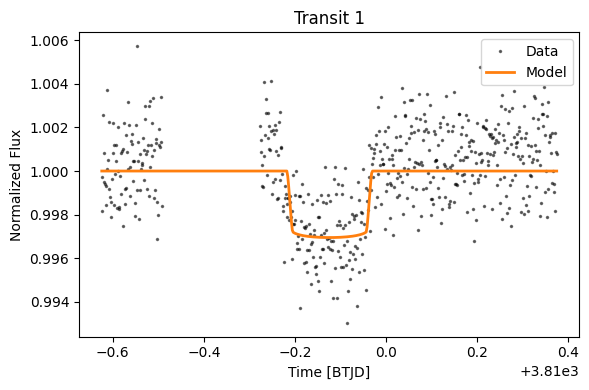

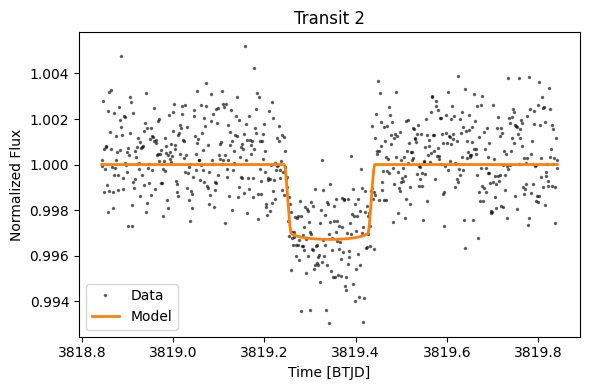

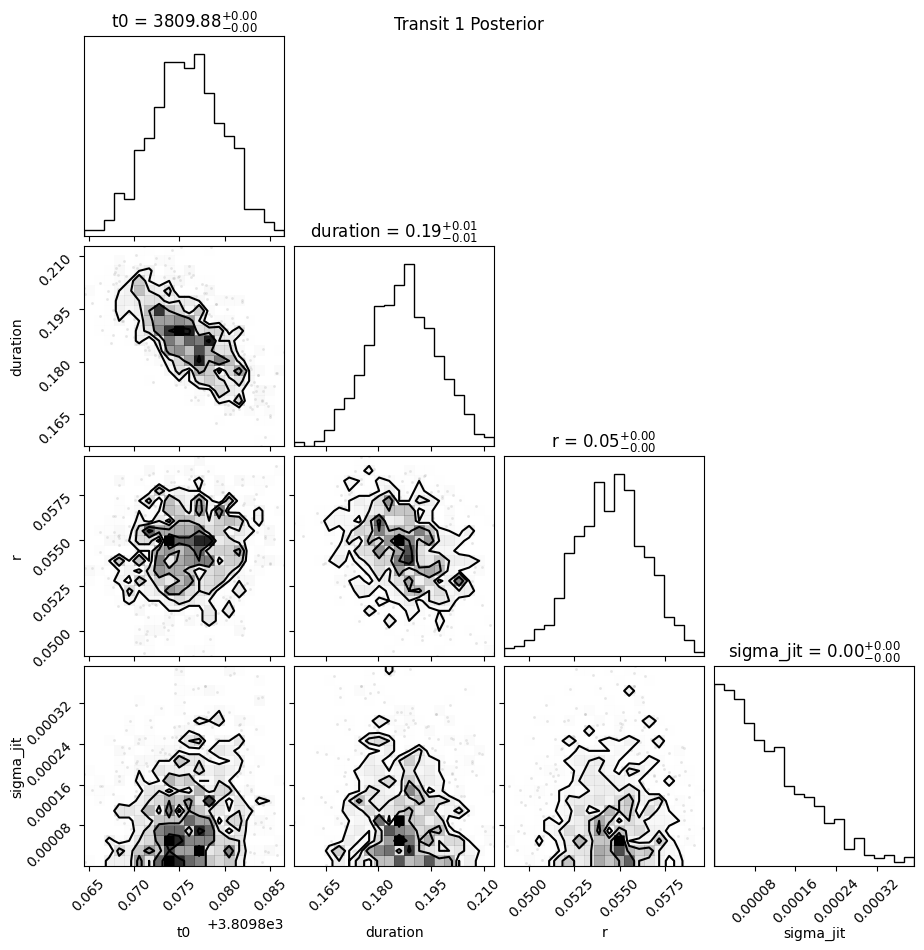

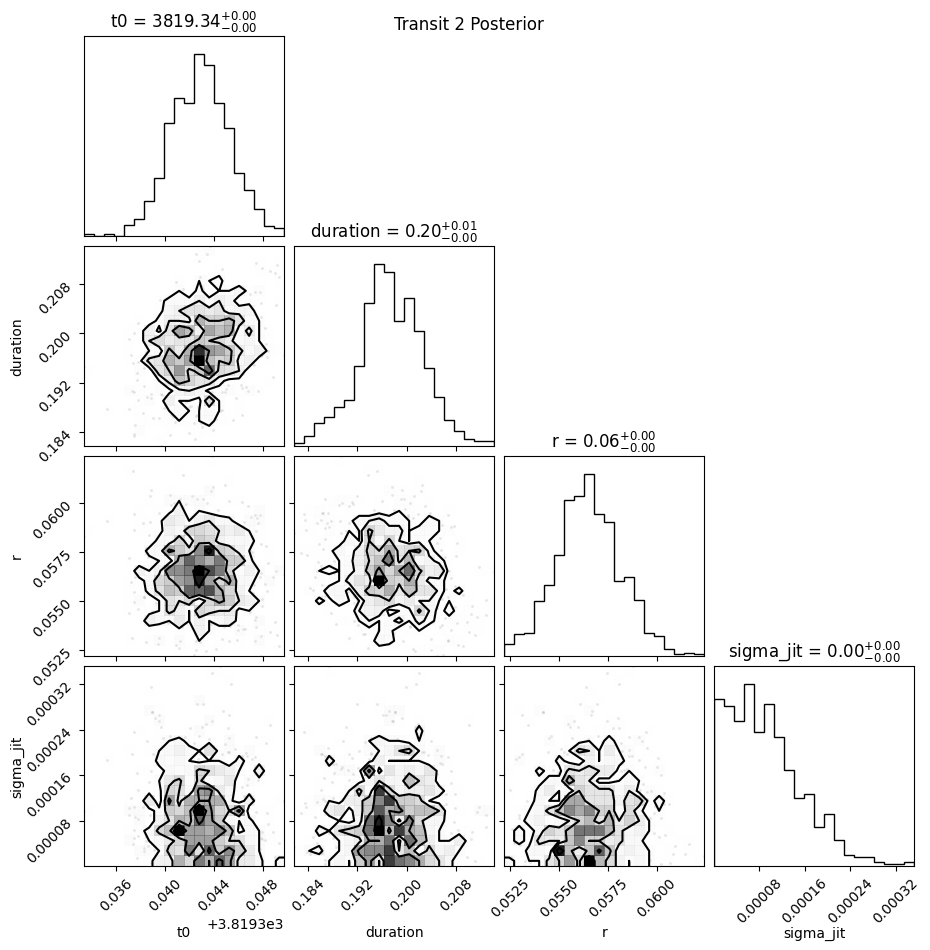

In [10]:
plot_transit_results(res, sector_data[(92,120)], window_size=0.5)


In [12]:
res = analyze_two_transits(
    sector_data[(95,120)],
    n_warmup=1500,
    n_samples=800,
    n_chains=1,
    window_size=0.5
)

sample: 100%|██████████| 2300/2300 [00:09<00:00, 241.97it/s, 7 steps of size 4.88e-01. acc. prob=0.86] 

          FINAL TRANSIT FIT RESULTS      

----- Transit 1 -----
t0        = 3885.68437829 ± 0.00193716
duration  = 0.191693 ± 0.004134 days
r         = 0.056442 ± 0.001574
depth     = 0.003188 (≈ r^2)
jitter    = 0.000085 ± 0.000064

----- Transit 2 -----
t0        = 3904.63882515 ± 0.00200823
duration  = 0.195390 ± 0.004561 days
r         = 0.059744 ± 0.001742
depth     = 0.003572 (≈ r^2)
jitter    = 0.000086 ± 0.000067

Estimated period = 18.954447 days


In [13]:
18.954447/2

9.4772235

In [14]:
res = analyze_two_transits(
    sector_data[(68,120)],
    n_warmup=1500,
    n_samples=800,
    n_chains=1,
    window_size=0.5
)

sample: 100%|██████████| 2300/2300 [00:06<00:00, 335.47it/s, 7 steps of size 5.34e-01. acc. prob=0.87] 

          FINAL TRANSIT FIT RESULTS      

----- Transit 1 -----
t0        = 3155.96258483 ± 0.00204571
duration  = 0.194973 ± 0.004627 days
r         = 0.056052 ± 0.001717
depth     = 0.003145 (≈ r^2)
jitter    = 0.000087 ± 0.000068

----- Transit 2 -----
t0        = 3174.91976917 ± 0.00263563
duration  = 0.189177 ± 0.005619 days
r         = 0.057280 ± 0.001894
depth     = 0.003285 (≈ r^2)
jitter    = 0.000106 ± 0.000080

Estimated period = 18.957184 days


In [15]:
18.957184/2

9.478592

In [16]:
res = analyze_two_transits(
    sector_data[(28,20)],
    n_warmup=1500,
    n_samples=800,
    n_chains=1,
    window_size=0.5
)

sample: 100%|██████████| 2300/2300 [00:26<00:00, 86.65it/s, 7 steps of size 3.33e-01. acc. prob=0.94]  

          FINAL TRANSIT FIT RESULTS      

----- Transit 1 -----
t0        = 2066.11861718 ± 0.00185563
duration  = 0.196843 ± 0.004062 days
r         = 0.053527 ± 0.001422
depth     = 0.002867 (≈ r^2)
jitter    = 0.000136 ± 0.000108

----- Transit 2 -----
t0        = 2075.59917833 ± 0.00280261
duration  = 0.192821 ± 0.006192 days
r         = 0.053510 ± 0.001364
depth     = 0.002865 (≈ r^2)
jitter    = 0.000148 ± 0.000105

Estimated period = 9.480561 days


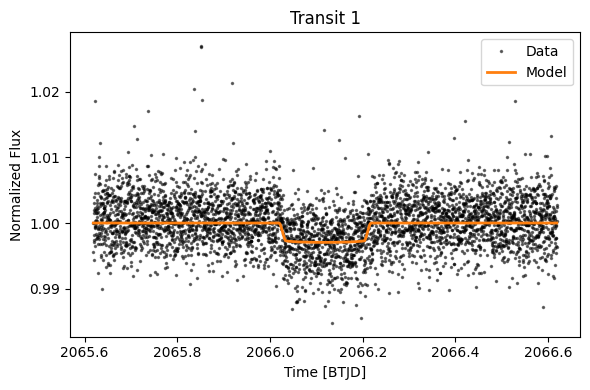

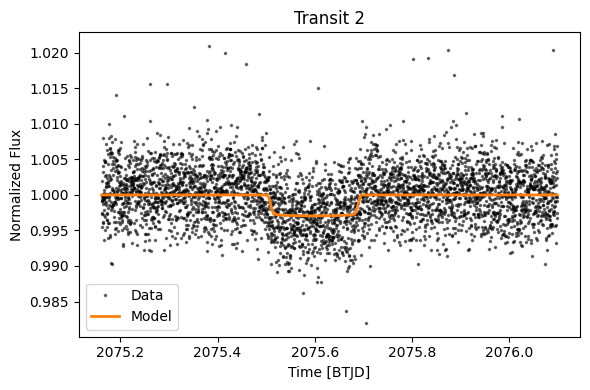

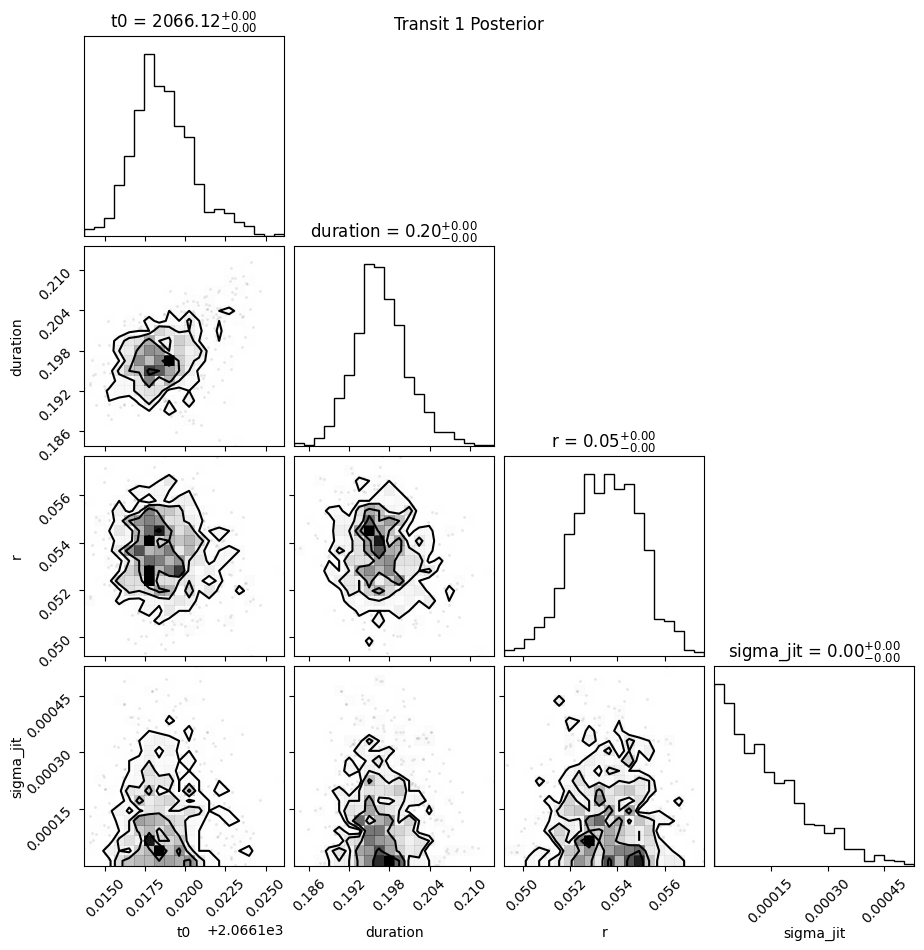

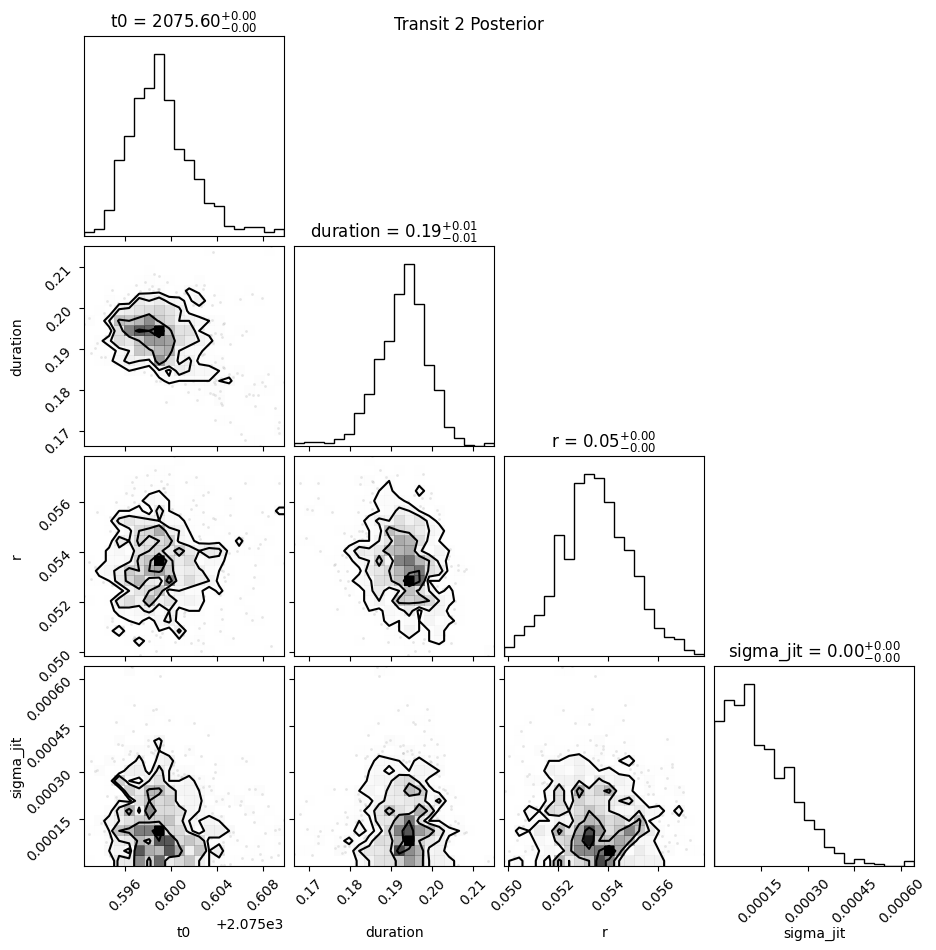

In [18]:
plot_transit_results(res, sector_data[(28,20)], window_size=0.5)


In [ ]:
#P = 9.47725 ± 0.00064 days
#r = Rp/R* = 0.05588 ± 0.00091
#depth ≈ r² = 0.00312 → 3120 ± 100 ppm


In [23]:
import lightkurve as lk
import numpy as np

def download_sector_120s(tic_id, author="SPOC", exptime_target=120.0):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    tbl = search.table
    data = {}

    mask120 = tbl["exptime"] == exptime_target
    tbl = tbl[mask120]
    search = search[mask120]

    if len(tbl) == 0:
        print(f"No 120s cadence data for TIC {tic_id}.")
        return data

    sectors = np.unique(tbl["sequence_number"])

    for sec in sectors:
        mask = tbl["sequence_number"] == sec
        sub = tbl[mask]

        idx = np.arange(len(tbl))[mask][0]
        row = search[idx]

        print(f"Downloading TIC {tic_id} Sector {sec} (exptime={exptime_target}s) ...")

        lc = (row.download(flux_column="pdcsap_flux")
                 .remove_nans()
                 .normalize())

        key = (int(sec), float(exptime_target))
        data[key] = lc

    return data


sector_data = download_sector_120s(29857954)


sample: 100%|██████████| 2300/2300 [00:09<00:00, 253.60it/s, 7 steps of size 5.06e-01. acc. prob=0.88] 


          FINAL TRANSIT FIT RESULTS      

----- Transit 1 -----
t0        = 2066.11707494 ± 0.00189002
duration  = 0.195239 ± 0.004240 days
r         = 0.052429 ± 0.001751
depth     = 0.002752 (≈ r^2)
jitter    = 0.000092 ± 0.000071

----- Transit 2 -----
t0        = 2075.59709536 ± 0.00253317
duration  = 0.195222 ± 0.005715 days
r         = 0.056668 ± 0.001656
depth     = 0.003214 (≈ r^2)
jitter    = 0.000088 ± 0.000063

Estimated period = 9.480020 days


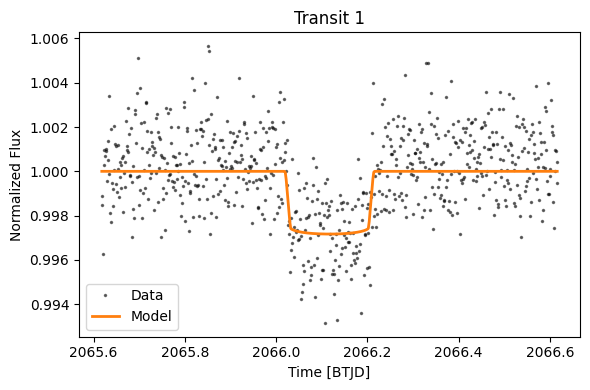

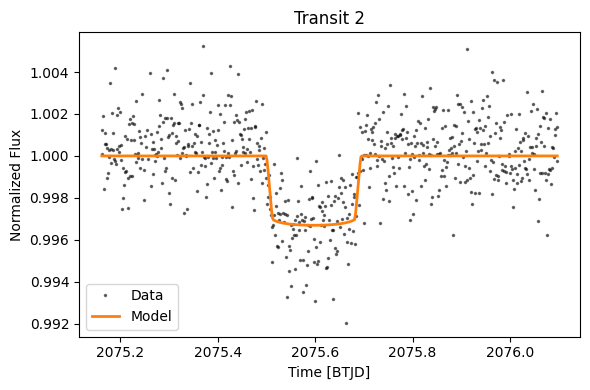

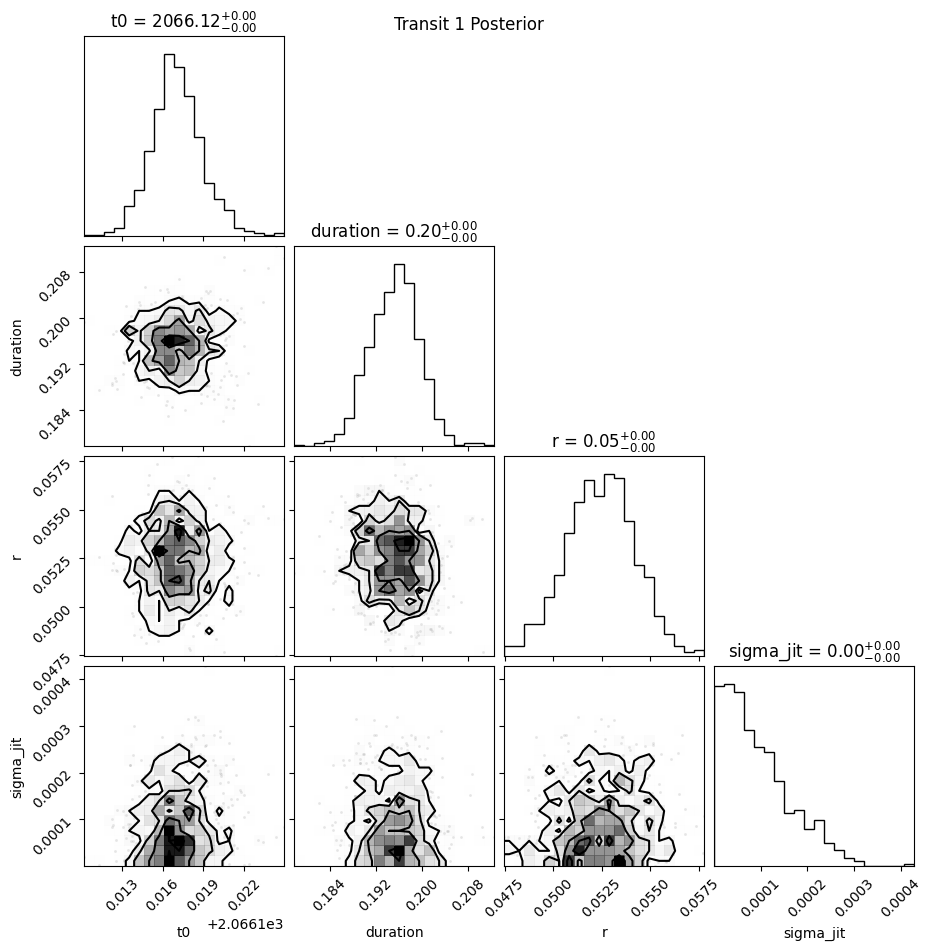

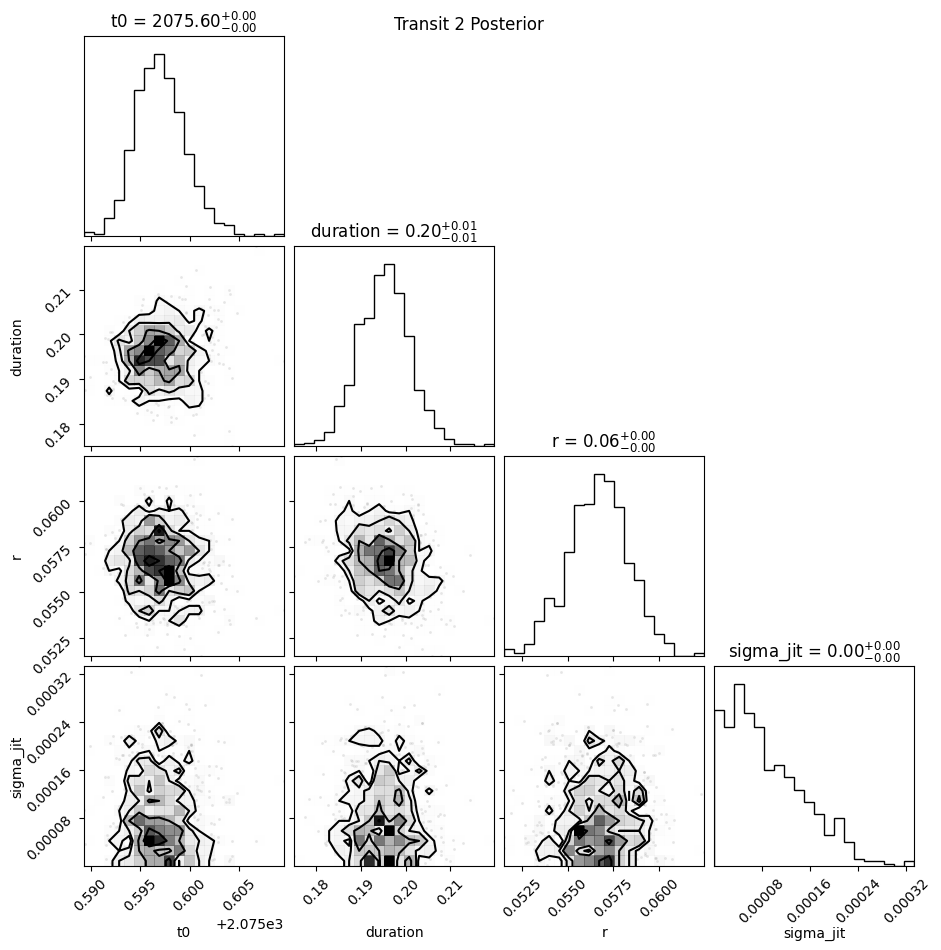

In [24]:
res = analyze_two_transits(
    sector_data[(28,120)],
    n_warmup=1500,
    n_samples=800,
    n_chains=1,
    window_size=0.5
)
plot_transit_results(res, sector_data[(28,120)], window_size=0.5)
